In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from utils import *

In [4]:
datas = []
for i in range(1,5):
    data = pd.read_csv("../data/funda_train_%d주.csv"%(i))
    data["Date"] = data["Date"]=pd.to_datetime(data["Date"], format="%Y-%m-%d")
    datas.append(data)

### 기간별 데이터셋 리딩

In [3]:
sample = datas[0]["store_id"].sample(10)

In [8]:
def decompostion_plot(sample,data,id_col,int_col):
    for i in sample.tolist():
        try:
            result = seasonal_decompose(np.log1p(data[data[id_col]==i][int_col]), model='multiplicative')
            fig = result.plot()
            plot_mpl(fig)
            fig
        except:
            print(i)
    return fig

C:\Users\LeeWonSeok\Anaconda3\envs\django\lib\site-packages\plotly\matplotlylib\mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

C:\Users\LeeWonSeok\Anaconda3\envs\django\lib\site-packages\plotly\matplotlylib\mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



1195


C:\Users\LeeWonSeok\Anaconda3\envs\django\lib\site-packages\plotly\matplotlylib\mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

C:\Users\LeeWonSeok\Anaconda3\envs\django\lib\site-packages\plotly\matplotlylib\mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

C:\Users\LeeWonSeok\Anaconda3\envs\django\lib\site-packages\plotly\matplotlylib\mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



1613


C:\Users\LeeWonSeok\Anaconda3\envs\django\lib\site-packages\plotly\matplotlylib\mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



1730


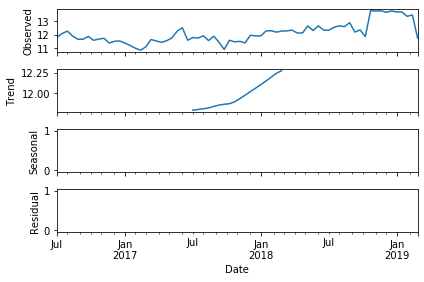

In [9]:
decompostion_plot(sample,datas[0],"store_id","amount")

## Auto arima 모형 소개
- 최적 parmater를 자동으로 찾아서 arima모델을 fitting 해줌
- 기본적으로 p(AR),d(차분),q(MR) 파라미터를 튜닝
- 계절성분 추가시 SARMIA의 P,Q,R 도 튜닝할 수 있음
- AIC,AICC,BIC,HQIC,OOB 등을 고려하여 다음 값이 가장 작은 모델을 리턴함
- oob 는 Out of bag 방식
## Parameter
- y : 예측할 값(nan,inf 혀용 x)
- exogenous : y값이외의 추가 데이터 사용 예측(2차원 array 형태로 input)
- information_criterion : aic,bic,oob 등 피팅기준
- start_p : ARIMA(p,d,q)의 grid_search p 시작값
- start_q : ARIMA(p,d,q)의 grid_search q 시작값
- max_p : ARIMA(p,d,q)의 grid_search p 최대값
- max_q : ARIMA(p,d,q)의 grid_search q 최대값
- d : ARIMA(p,d,q)의 차분성분(None이면 알아서 하지만 long time 보통 1,2 안에)
- start_P : SARIMA(P,D,Q)의 grid_search p 시작값
- start_Q : SARIMA(P,D,v)의 grid_search q 시작값
- max_P : SARIMA(P,D,Q)의 grid_search p 최대값
- max_Q : SARIMA(P,D,Q)의 grid_search q 최대값
- D : SARIMA(p,D,q)의 차분성분(None이면 알아서 하지만 long time 보통 1,2 안에)
- max_order : ARIMA(p,d,q)의 p와 q의 합 최대를 제한 (default 5, None이면 제약없음)
- m : season parameter , 계절을 얼마나 할건지(ex 4계절 4, 월별 12 등 상황따라)
- seasonal : SARIMA 할건지 정하는것  m==1 일 땐 알아서 False임
- stationary : 정상시계열인지 아닌지 True일 때 d==0 이어야함
- stepwise : 단계적선택법을 적용해 paramter 찾을지 여부 (True 추천)
- n_jobs : 지정한 수 범위내에서 가능한 arima model 다 fitting함
- trend : 추세다항식성분 넣을건지 "c" 상수, "t" 1차항하나 , "ct" 상수랑 1차항둘다
- supress_warnings : arima 모델추정시 발생할수있는  warning 무시할건지 
- error_action : 피팅도중 error 발생시 행동 ("ignore","warn")
- trace : 피팅되는과정  print할지말지  
- random : 랜덤 서칭으로 parameter찾음 (단계적이 false일때 씀)
- n_fits : 랜덤 서칭으로 몇번 iteration할건지
- out_of_sample_size : 피팅할때 데이터꼬리 일부를 빼놓는 방식(검증용) , self.arima_res_.data.endog values에 있음
- scoring : {mae,mse} 기준으로 out_of_sample_size>0일 때 검증함

### arima parmeter tunning plan
1. ARIMA(0,0,0) ~ ARIMA(10,2,10) 까지 
2. SARIMA(0,0,0) ~ SARIMA(5,2,5) 까지
3. stepwise = True
4. seasonal = {True, False}
5. m = {half:2,season:4,month:12}
6. out_sample => {1주 :4, 2주:2, 3주:2, 4주:1}
7. scoring = mae
8. supress_warnings = True
9. error_action = "ignore"
10. trend = ["c","t","ct"]

In [10]:
# 주차별 결과 테이블로 나타내기
# 모델링 경과 MAE가 가장 좋은 모델 쓰기
# 피팅된 모델 결과도 기록하기
total_mean_result = pd.DataFrame(columns=["unit","mae","rmse","mae_log","rmse_log"]) 
for unit,data in enumerate(datas,1):
    total_result = pd.DataFrame(columns=["store_id","mae","rmse","mae_log","rmse_log"])
    store_id_lst = data["store_id"].unique()
    for ids in store_id_lst:
        # id filtering and train test split
        each_store = data[data["store_id"]==ids]
        store_train = each_store[each_store["Date"]<'2019-01-01']
        store_test = each_store[each_store["Date"]>='2019-01-01']
        test_period = len(store_test)
        # gird search modeling
        modeling = time_model(np.log1p(store_train["amount"].values))
        result_model = modeling.auto_arimga_grid()
        MAE_result = []
        y_true = store_test["amount"].values
        y_true_log = np.log1p(y_true)
        # best model select
        for each_model in result_model:
            pred = each_model.predict(n_periods = test_period)
            pred = np.expm1(pred)
            mae = modeling.MAE(y_true,pred)
            MAE_result.append(mae)
        best_model = result_model[np.argmin(MAE_result)]
        # calculate metrics
        best_mae = np.min(MAE_result)
        y_pred_log = best_model.predict(n_periods = test_period)
        y_pred = np.expm1(y_pred_log)
        best_rmse = modeling.RMSE(y_true,y_pred)
        mae_log = modeling.MAE(y_true_log,y_pred_log)
        rmse_log = modeling.RMSE(y_true_log,y_pred_log)
        # save_best_model
        modeling.save_model(best_model,'../model/model_%d_%d.sav'%(unit,ids))
        # append reulst to DataFrame
        mini_result = pd.DataFrame.from_dict([{"store_id" :ids,
                                    "mae":best_mae,
                                    "rmse":best_rmse,
                                     "mae_log":mae_log,
                                      "rmse_log":rmse_log}])
        total_result = pd.concat([total_result,mini_result],axis=0,sort=False)
        break
    # caulcate mean result
    mean_mae = total_result["mae"].mean()
    mean_rmse = total_result["rmse"].mean()
    mean_mae_log = total_result["mae_log"].mean()
    mean_rmse_log = total_result["rmse_log"].mean()
    mini_mean_result = pd.DataFrame.from_dict([{"unit":unit,
                                    "mae":mean_mae,
                                    "rmse":mean_rmse,
                                    "mae_log":mean_mae_log,
                                    "rmse_log":mean_rmse_log}])
    total_mean_result = pd.concat([total_mean_result,mini_mean_result],axis=0,sort=False)
    # result to excel
    total_result.to_excel("../result/each_store_result_%d.xlsx"%(unit))
    break
total_mean_result.to_excel('../result/total_unit_result.xlsx')

model save complete
